In [2]:
import sys
import os

# Get the path to the validate_assay folder
module_path = os.path.abspath(os.path.join('..', 'validate_assay'))

# Add the folder to the system path
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from venn import venn
from pcrvalidationtools import *

In [4]:
# files 
DATA_PATH = "../Data/v4_08262024/"
datasets_file = DATA_PATH + 'ev_metadata_filtered.tsv'
assay0_file = DATA_PATH + 'ev_db/' + 'assay0.tsv'
assay1_file = DATA_PATH + 'ev_db/' + 'assay1.tsv'
assay2_file = DATA_PATH + 'ev_db/' + 'assay2.tsv'
assay8_file = DATA_PATH + 'ev_db/' + 'assay8.tsv'
taxonomy_collapse_file = DATA_PATH + 'ev_taxonomy_collapse.tsv'

In [5]:
# read in filtered datasets
ev_data = pd.read_csv(datasets_file, sep='\t')

# get metadata for target assay hits 
assay0 = assess_data(ev_data, get_accessions(assay0_file)) 
assay1 = assess_data(ev_data, get_accessions(assay1_file)) 
assay2 = assess_data(ev_data, get_accessions(assay2_file)) 
assay8 = assess_data(ev_data, get_accessions(assay8_file)) 

In [6]:
assay0_hits = set(assay0[assay0['Hit']]['Accession'].copy())
assay1_hits = set(assay1[assay1['Hit']]['Accession'].copy())
assay2_hits = set(assay2[assay2['Hit']]['Accession'].copy())
assay8_hits = set(assay8[assay8['Hit']]['Accession'].copy())

In [7]:
assays = {'Assay 0': assay0,
          'Assay 1': assay1,
          'Assay 2': assay2,
          'Assay 8': assay8}

In [8]:
assays_hits = {}

for assay_name, assay in assays.items():
    assays_hits[assay_name] = set(assay[assay['Hit']]['Accession'].copy())

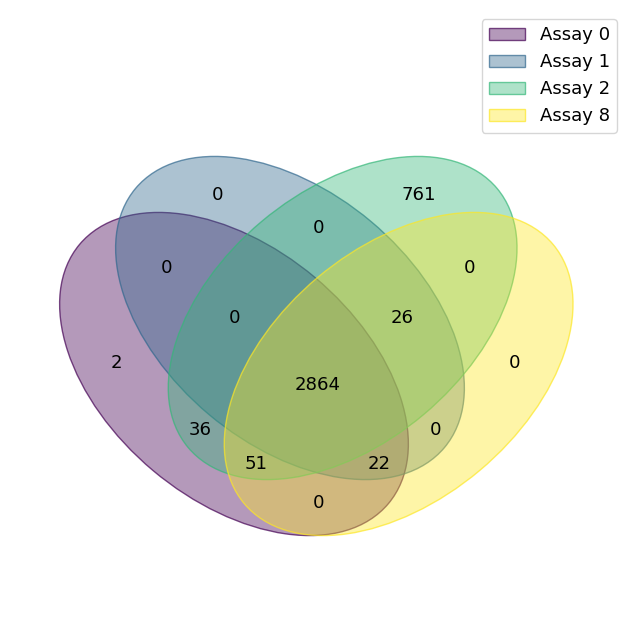

In [9]:
venn(assays_hits)
plt.savefig('venn.svg', dpi=300, bbox_inches='tight')

In [10]:
# provide the label and taxid of species of interest 
txids = {'EV-A': 138948, 'EV-B': 138949, 'EV-C': 138950, 'EV-D': 138951}

# read in collpased taxonomy info 
taxonomy_collapse = pd.read_csv(taxonomy_collapse_file, sep='\t')
taxonomy_collapse

,Virus Taxonomic ID,Collapse TaxId,Collapse Name
0,1435148,138948,Enterovirus A
1,185889,147712,Rhinovirus B
2,185891,147711,Rhinovirus A
3,2094116,463676,Rhinovirus C
4,185893,147711,Rhinovirus A
...,...,...,...
166,35293,138949,Enterovirus B
167,35295,138949,Enterovirus B
168,35294,138949,Enterovirus B
169,297248,138948,Enterovirus A


In [11]:
# df: dataframe of virus taxids and their group taxid
# group_taxids: dictionary of label to taxids for the groups that we are interested in
# returns a dataframe where the key is the group taxid and the value is a list of taxids that fall within that group (including itself)
def group_taxids(df, group_taxids):
    taxid_groups = {}
    for group_label, group_taxid in group_taxids.items():
        group = df[df['Collapse TaxId'] == group_taxid].copy()
        taxid_groups[group_label] = group['Virus Taxonomic ID'].tolist()
        taxid_groups[group_label].append(group_taxid)
    return taxid_groups

In [12]:
def group_accessions(assay_df, taxid_groups): 
    acc_groups = {}
    assay_df = assay_df[assay_df['Hit']].copy()
    for group_name, group_taxids in taxid_groups.items():
        group = assay_df[assay_df['Virus Taxonomic ID'].isin(group_taxids)].copy()
        acc_groups[group_name] = group['Accession'].tolist()
    return acc_groups

In [13]:
# taxid_groups[TAXID] -> list of taxids that fall under TAXID
taxid_groups = group_taxids(taxonomy_collapse, txids)

In [14]:
# assays_grouped[assay_name][group_name]
# assays_grouped['Assay 0']['EV-A']
assays_grouped = {}
for assay_name, assay in assays.items():
    assays_grouped[assay_name] = group_accessions(assay, taxid_groups)

In [15]:
# grouped_assays[group_name][assay_name]
grouped_assays = {}
for group_name in txids.keys():
    group = {}
    for assay_name in assays_grouped:
        group[assay_name] = set(assays_grouped[assay_name][group_name])
    grouped_assays[group_name] = group

In [16]:
def plot_comparison_subspecies(grouped_assays):
    fig, axs = plt.subplots(2, 2, figsize=(20,15))
    for ax, group in zip(axs.flatten(), grouped_assays):
        venn(grouped_assays[group], ax=ax, cmap='viridis')
        ax.set_title(group) 

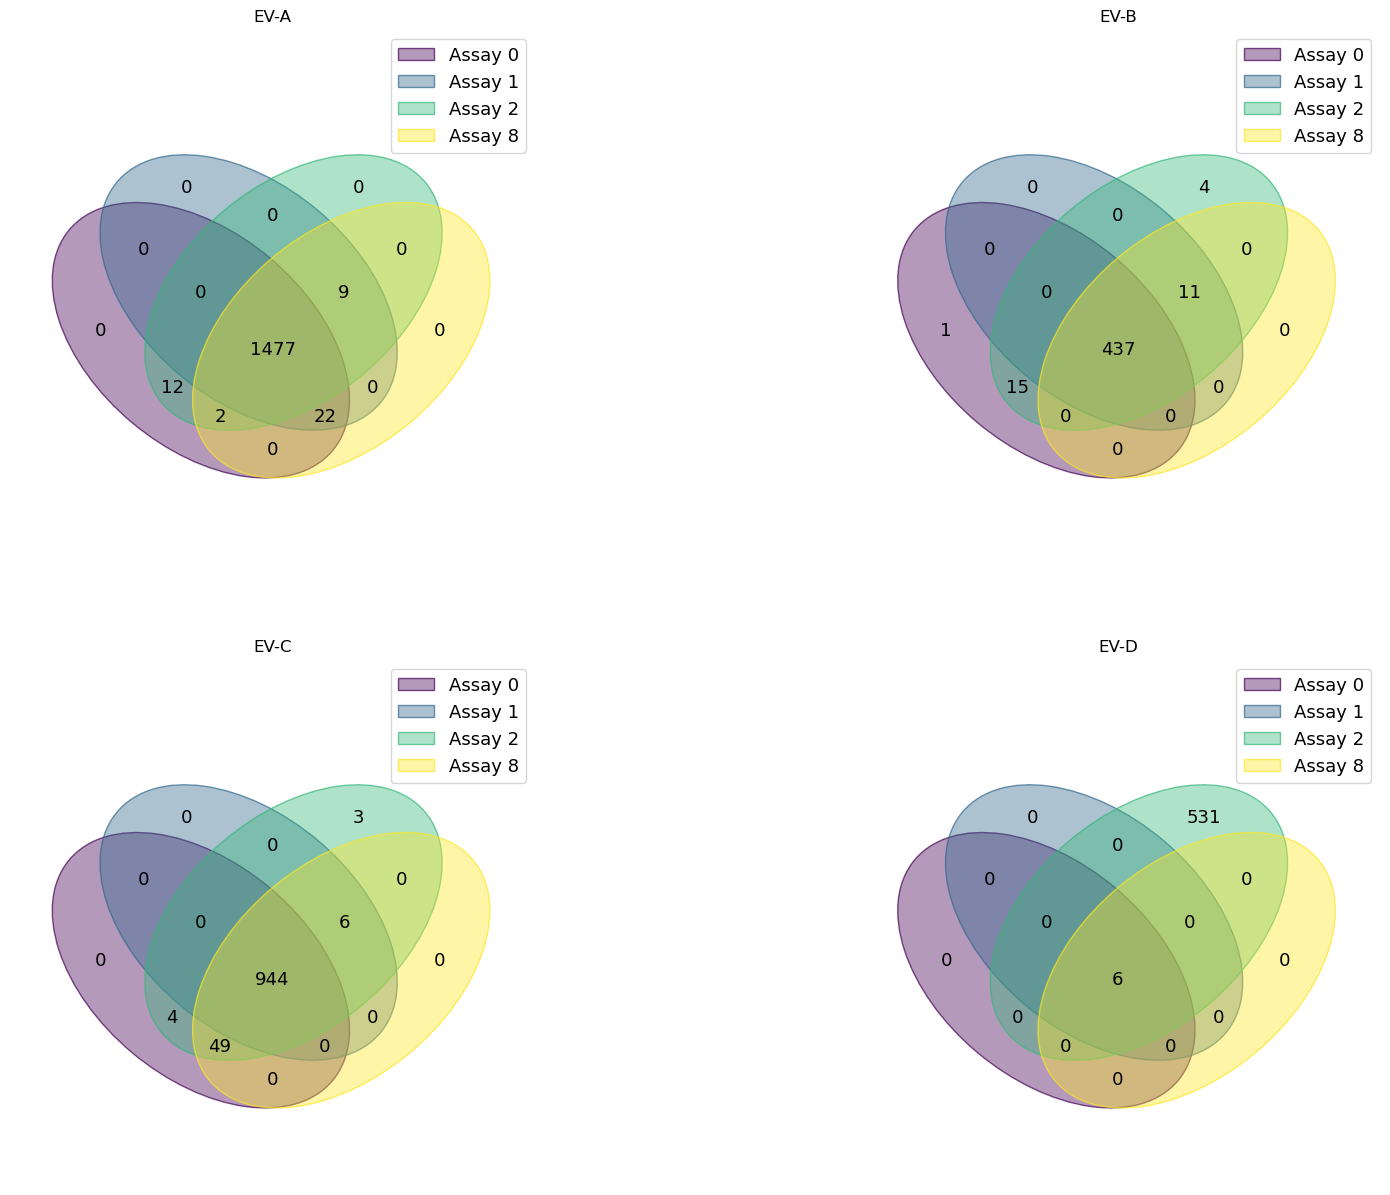

In [17]:
plot_comparison_subspecies(grouped_assays)
plt.savefig('venn_subplot.svg', dpi=300, bbox_inches='tight')